In [1]:
class_to_idx = {'palazzos': 0,
 'blouse': 1,
 'saree': 2,
 'lehenga': 3,
 'gowns': 4,
 'sherwanis': 5,
 'women_kurta': 6,
 'nehru_jackets': 7,
 'leggings_and_salwars': 8,
 'dupattas': 9,
 'mojaris_men': 10,
 'kurta_men': 11,
 'dhoti_pants': 12,
 'petticoats': 13,
 'mojaris_women': 14}

In [2]:
import json
import numpy as np
from PIL import Image

json_path = '/kaggle/input/indo-fashion-dataset/train_data.json'
image_path = '/kaggle/input/indo-fashion-dataset/images/train/'

input_data = []
input_data_im_cl = []
labels = []
import time
st = time.time()
ctr=0
with open(json_path, 'r') as f:
	for line in f:
		obj = json.loads(line)
		input_data.append(obj)
		tmp = {'image': '/kaggle/input/indo-fashion-dataset/'+obj['image_path'],
               'caption': obj['class_label']}
		input_data_im_cl.append(tmp)
# 		if ctr%100==0:
# 			print(f"CTR : {ctr}", end="\r", flush=True)  
# 		ctr+=1
        
et = time.time()
print(f'Time Taken: {et-st}')

Time Taken: 0.7849001884460449


In [3]:
def check_im_size(image_path):
    if np.array(Image.open(image_path)).size<1000:
        return False
    else:
        return True
                

In [4]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Number of workers (threads); you can adjust this based on your task and system capabilities
num_workers = 4
inputs = [x['image'] for x in input_data_im_cl]

# Use ThreadPoolExecutor to parallelize tasks
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Map the worker_task over inputs and wrap with tqdm for progress reporting
    # The results will be in the same order as the inputs
    results = list(tqdm(executor.map(check_im_size, inputs), total=len(inputs)))

100%|██████████| 91166/91166 [04:07<00:00, 367.91it/s]


In [5]:
input_data_im_cl_ref = []
for item, b in zip(input_data_im_cl, results):
    if b:
        input_data_im_cl_ref.append(item)
len(input_data_im_cl_ref), len(input_data_im_cl)

(91162, 91166)

In [6]:
classes = []
for item in input_data_im_cl_ref:
    classes.append(item['caption'])
    
from collections import Counter
Counter(classes)

Counter({'women_kurta': 11694,
         'saree': 10791,
         'blouse': 9174,
         'leggings_and_salwars': 7787,
         'kurta_men': 6951,
         'dupattas': 6587,
         'nehru_jackets': 6490,
         'lehenga': 5752,
         'gowns': 5211,
         'petticoats': 4441,
         'dhoti_pants': 4145,
         'palazzos': 3374,
         'mojaris_women': 3228,
         'sherwanis': 2991,
         'mojaris_men': 2546})

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.DataFrame(input_data_im_cl_ref)
trainx, valx, trainy, valy = train_test_split(df['image'], df['caption'],
                                              stratify = df['caption'], shuffle = True,
                                              test_size=0.2, random_state = 42)

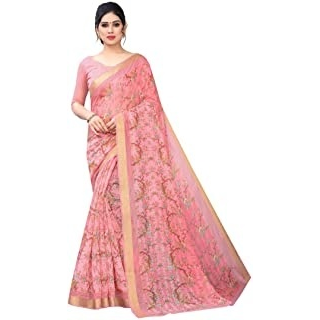

In [21]:
from PIL import Image

def create_square_layout(image_path, background_color=(255, 255, 255)):
    """
    Create a square layout of the max dimension of the image and place the image on the layout.

    Args:
        image_path (str): Path to the original image.
        background_color (tuple): Background color for the square layout in RGB format. Default is white.

    Returns:
        PIL.Image: The resulting image with a square layout.
    """
    # Load the original image
    image = Image.open(image_path)

    # Determine the size of the new square layout
    max_dim = max(image.size)
    square_layout = Image.new('RGB', (max_dim, max_dim), background_color)

    # Calculate the position to paste the original image on the square layout
    x = (max_dim - image.size[0]) // 2
    y = (max_dim - image.size[1]) // 2

    # Paste the original image onto the square layout
    square_layout.paste(image, (x, y))

    return square_layout

# Usage example
image_path = trainx[3]  # Update this to your image path
resulting_image = create_square_layout(image_path, background_color=(255, 255, 255))

# Display the resulting image
resulting_image

# Optionally, save the resulting image
# resulting_image.save("path/to/save/square_layout.jpg")


In [51]:
from transformers import CLIPProcessor
from torch.utils.data import Dataset, DataLoader
import torch

class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            item = self.data[idx]
            image = create_square_layout(item['image'], background_color=(255, 255, 255)).convert("RGB")
            #image = Image.open(item['image']).convert("RGB")
            caption = "a photo of a "+item['caption']
            label = class_to_idx[item['caption']]

            # Process image and text through CLIPProcessor
            processed = self.processor(text=caption, images=image, return_tensors="pt",
                                       padding="max_length", truncation=True,
              max_length=77)
        
        except Exception as e:
            print(idx)
            print(f"exception {e}")
            
        #processed['pixel_values'] = processed['pixel_values'][0]
        
        # Return label as well
        return processed.input_ids.squeeze(), processed.attention_mask.squeeze(), processed.pixel_values.squeeze(), torch.tensor(label)


In [52]:
from transformers import CLIPModel
import torch.nn as nn

# class FineTuneCLIP(nn.Module):
#     def __init__(self, num_labels=15):
#         super(FineTuneCLIP, self).__init__()
#         self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
#         self.classifier = nn.Linear(self.clip.text_model.config.hidden_size, num_labels)

#     def forward(self, input_ids, attention_mask, pixel_values):
#         outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, return_dict=True)
#         #text_features = outputs.text_embeds
#         text_features = outputs.image_embeds
#         logits = self.classifier(text_features)
#         return logits
    
class CLIPForCustomTask(nn.Module):
    def __init__(self, clip_model_name="openai/clip-vit-base-patch32", num_labels=15):
        super(CLIPForCustomTask, self).__init__()
        self.clip = CLIPModel.from_pretrained(clip_model_name)
        self.dropout = nn.Dropout(0.1)  # Example dropout layer
        self.task_head = nn.Linear(self.clip.config.projection_dim, num_labels)

    def forward(self, input_ids, attention_mask, pixel_values):
        outputs = self.clip(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values, return_dict=True)
        pooled_output = self.dropout(outputs.image_embeds)
        task_logits = self.task_head(pooled_output)
        return task_logits

In [53]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Apply this transform in your ImageCaptionDataset for the training dataset


In [54]:
train_dict = []
for x,y in zip(trainx, trainy):
    train_dict.append({'image':x,
                       'caption':y})
    
val_dict = []
for x,y in zip(valx, valy):
    val_dict.append({'image':x,
                     'caption':y})

In [55]:
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch
from PIL import Image
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import StepLR

In [56]:
# import gc
# del model
# gc.collect()
# torch.cuda.empty_cache()

In [57]:
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class Trainer:
    """
    A class used to train and validate a PyTorch model.

    Attributes:
    - device: The device (CPU or CUDA) on which to train the model.
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - history: Dictionary to store training and validation loss, accuracy, precision, and recall.

    Methods:
    - train_epoch(): Trains the model for one epoch on the training dataset.
    - validate_epoch(): Validates the model on the validation dataset.
    - train(num_epochs): Trains and validates the model for a specified number of epochs.
    - epoch_end(epoch, train_loss, val_loss, accuracy, precision, recall): Prints metrics at the end of an epoch.
    - plot_metrics(): Plots the training history including loss and accuracy metrics.
    """

    def __init__(self, model, train_dataset, val_dataset, batch_size=32, learning_rate=1e-3,
                 dataloader_kwargs=None, small_dataset = False, step_lr_factor=0.05,
                 step_lr_patience=3):
        """
        Initializes the Trainer class with the model, datasets, batch size, learning rate, and DataLoader parameters.

        Parameters:
        - model: The model to train.
        - train_dataset: The dataset used for training.
        - val_dataset: The dataset used for validation.
        - batch_size: The size of batches for training and validation (default is 32).
        - learning_rate: The learning rate for the optimizer (default is 1e-3).
        - **dataloader_kwargs: Additional keyword arguments for the DataLoader instances.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        # Modify DataLoader instantiation to accept additional keyword arguments
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **dataloader_kwargs)
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, **dataloader_kwargs)
        self.criterion = nn.CrossEntropyLoss()
        if small_dataset:
            self.optimizer = optim.AdamW(self.model.fc.parameters(), lr=learning_rate)  # Only optimize the final layer
        else:
            self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)
        
        self.history = {'train_loss': [], 'val_loss': [], 'accuracy': [], 'precision': [], 'recall': []}
        # Setup the learning rate scheduler
        #self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', factor=0.1, patience=5, verbose=True)
        self.step_lr_factor=step_lr_factor
        self.step_lr_patience=step_lr_patience
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', 
                                           factor=step_lr_factor, patience=step_lr_patience,
                                           verbose=True)

        

    def train_epoch(self):
        """Trains the model for one epoch over the training dataset."""
        self.model.train()  # Set the model to training mode
        total_loss = 0
        for input_ids, attention_mask, pixel_values, labels in tqdm(self.train_loader, total=len(self.train_loader)):
            input_ids, attention_mask, pixel_values, labels = input_ids.to(self.device), attention_mask.to(self.device), pixel_values.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()  # Clear gradients
            outputs = self.model(input_ids, attention_mask, pixel_values)  # Forward pass
            loss = self.criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            self.optimizer.step()  # Update model parameters
            
            total_loss += loss.item()  # Accumulate loss
        avg_loss = total_loss / len(self.train_loader)  # Calculate average loss
        return avg_loss

    def validate_epoch(self):
        """Validates the model on the validation dataset."""
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():  # Disable gradient computation
            for input_ids, attention_mask, pixel_values, labels in tqdm(self.val_loader, total=len(self.val_loader)):
                input_ids, attention_mask, pixel_values, labels = input_ids.to(self.device), attention_mask.to(self.device), pixel_values.to(self.device), labels.to(self.device)
                
                outputs = self.model(input_ids, attention_mask, pixel_values)
                loss = self.criterion(outputs, labels)
                
                total_loss += loss.item()
                _, preds = torch.max(outputs, 1)  # Get the predicted classes
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        return avg_loss, accuracy, precision, recall

    def train(self, num_epochs):
        """Trains and validates the model for a specified number of epochs."""
        for epoch in range(num_epochs):
            train_loss = self.train_epoch()  # Train for one epoch
            val_loss, accuracy, precision, recall = self.validate_epoch()  # Validate
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['accuracy'].append(accuracy)
            self.history['precision'].append(precision)
            self.history['recall'].append(recall)
            # Print metrics for the epoch
            self.epoch_end(epoch, train_loss, val_loss, accuracy, precision, recall)
            
            # Scheduler step with validation loss
            self.scheduler.step(val_loss)

    def epoch_end(self, epoch, train_loss, val_loss, accuracy, precision, recall):
        """Prints the metrics at the end of an epoch."""
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    def plot_metrics(self):
        """Plots the training and validation loss, accuracy, precision, and recall over epochs."""
        epochs = range(len(self.history['train_loss']))
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.history['train_loss'], label='Training Loss')
        plt.plot(epochs, self.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.history['accuracy'], label='Accuracy')
        plt.plot(epochs, self.history['precision'], label='Precision')
        plt.plot(epochs, self.history['recall'], label='Recall')
        plt.title('Accuracy, Precision, and Recall')
        plt.legend()
        plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Train Loss: 2.5953, Validation Loss: 2.5906, Accuracy: 0.1359, Precision: 0.0339, Recall: 0.0711


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Train Loss: 2.5322, Validation Loss: 2.4983, Accuracy: 0.2102, Precision: 0.0538, Recall: 0.1187


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2, Train Loss: 2.4398, Validation Loss: 2.4236, Accuracy: 0.2336, Precision: 0.0659, Recall: 0.1359


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3, Train Loss: 2.4290, Validation Loss: 2.4101, Accuracy: 0.2266, Precision: 0.0700, Recall: 0.1315


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4, Train Loss: 2.3319, Validation Loss: 2.2941, Accuracy: 0.2812, Precision: 0.1026, Recall: 0.1727


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.2940, Validation Loss: 2.3124, Accuracy: 0.2820, Precision: 0.1029, Recall: 0.1806


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6, Train Loss: 2.2649, Validation Loss: 2.2615, Accuracy: 0.2820, Precision: 0.1076, Recall: 0.1866


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7, Train Loss: 2.2229, Validation Loss: 2.2335, Accuracy: 0.2844, Precision: 0.1183, Recall: 0.1830


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8, Train Loss: 2.2263, Validation Loss: 2.2816, Accuracy: 0.2625, Precision: 0.1617, Recall: 0.1735


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9, Train Loss: 2.1929, Validation Loss: 2.1839, Accuracy: 0.3141, Precision: 0.1927, Recall: 0.2097


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10, Train Loss: 2.1200, Validation Loss: 2.1345, Accuracy: 0.3242, Precision: 0.2053, Recall: 0.2291


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11, Train Loss: 2.0342, Validation Loss: 2.0049, Accuracy: 0.3547, Precision: 0.2154, Recall: 0.2656


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12, Train Loss: 2.0199, Validation Loss: 2.0099, Accuracy: 0.3461, Precision: 0.1832, Recall: 0.2441


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13, Train Loss: 1.9843, Validation Loss: 2.0914, Accuracy: 0.3469, Precision: 0.2421, Recall: 0.2759


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14, Train Loss: 1.9851, Validation Loss: 2.1589, Accuracy: 0.3086, Precision: 0.1916, Recall: 0.2317


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15, Train Loss: 2.0149, Validation Loss: 1.9846, Accuracy: 0.3609, Precision: 0.2269, Recall: 0.2603


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16, Train Loss: 1.9529, Validation Loss: 1.9805, Accuracy: 0.3742, Precision: 0.2909, Recall: 0.2878


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17, Train Loss: 1.9316, Validation Loss: 2.0135, Accuracy: 0.3750, Precision: 0.2376, Recall: 0.2880


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18, Train Loss: 1.9817, Validation Loss: 2.1601, Accuracy: 0.3258, Precision: 0.1838, Recall: 0.2338


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19, Train Loss: 2.1233, Validation Loss: 2.1275, Accuracy: 0.3211, Precision: 0.2043, Recall: 0.2312


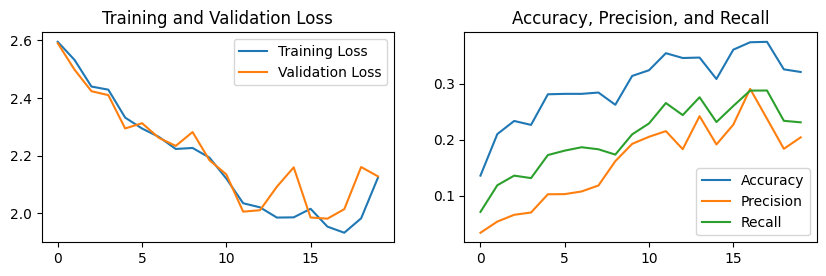

In [58]:
model = CLIPForCustomTask().to("cuda")
train_dataset = ImageCaptionDataset(train_dict[:12800])#, transform=train_transform)
valid_dataset = ImageCaptionDataset(val_dict[:1280])
cuda_kwargs = {'num_workers': 4,
               'pin_memory': True}

trainer = Trainer(model, train_dataset, valid_dataset, batch_size=128, learning_rate=1e-3,
                  dataloader_kwargs=cuda_kwargs, step_lr_factor=0.5, step_lr_patience=3)
trainer.train(num_epochs=20)
trainer.plot_metrics()

In [ ]:
import torch
checkpoint = {'model': CLIPForCustomTask(),
              'state_dict': trainer.model.state_dict(),
              'optimizer' : trainer.optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')